# Generate music with an RNN


## Setup

In [110]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [111]:
pip install fluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import os

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
from google.colab import files

In [114]:
#data_folder = 'midi_chopin_format_0_dataset' #to input as a string
#data_path = os.path.join('..','..','raw_data', data_folder)
#data_path = pathlib.Path(data_path)
data_path = pathlib.Path('drive/MyDrive/Colab Notebooks/tensorflow-music-generation/data/midi_chopin_format_0_dataset')
filenames = glob.glob(str(data_path/"*.mid"))
print('Number of files:', len(filenames))

Number of files: 131


In [115]:
# General parameters 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE = 16000 # Sampling rate for audio playback
vocab_size = 128 # Represents the number of note pitches 
key_order = ['pitch', 'step', 'duration'] # Features we keep

# Hyper-parameters 
seq_length = 25
batch_size = 32
pitch_weight= 0.05
step_weight = 1.0
duration_weight = 1.0
patience = 5
epochs = 100
learning_rate = 0.001

# Parameters used to generate the music notes
temperature = 2
file_number = 1 #Choose one file among the existing file to start the prediction 
sample_file = filenames[file_number]
raw_notes = midi_to_notes(sample_file)
#example_file = 'example.midi'
#example_pm = notes_to_midi(
#    raw_notes, out_file=example_file, instrument_name=instrument_name)
pm = pretty_midi.PrettyMIDI(sample_file)
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

## Fetch dataset

## Functions

In [116]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [117]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [118]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [119]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [120]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [121]:
# TODO : Add padding on each piano records 
# TODO : Discuss/Ask about scaling for duration, steps 

def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels = targets = predicted notes
  # shift : spacing between two windows
  # stride : inside a given window, spacing between two notes ==> we don't want to skip notes so we take stride = 1*
  # drop_remainder : representing whether the last windows should be dropped if their size is smaller than size
    
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [122]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [123]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

## Create the training dataset

In [124]:
def create_train_ds_per_file(filename) :

    notes = midi_to_notes(filename)

    #Fetching features and transform to tensorflow dataset 
    train_notes = np.stack([notes[key] for key in key_order], axis=1) #Keeps columns of key_order and transform to numpy.ndarray format
    notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)

    seq_length_temp = seq_length+1
    #Creating windows 
    windows = notes_ds.window(seq_length_temp, shift=1, stride=1,
                                  drop_remainder=True)
    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length_temp, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    seq_ds = sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)
        
    return seq_ds 

In [126]:
#Concatenate all batches of sequences by instanciating on the first file
seq_ds_all = create_train_ds_per_file(filenames[0])

for filename in filenames[1:] :
    seq_ds = create_train_ds_per_file(filename)
    seq_ds_all = seq_ds_all.concatenate(seq_ds)



In [127]:
#Shuffling batches and optmizing the training dataset for CPU speed
nb_elem_all = 247489 #HARDCODED - To discuss 
buffer_size = nb_elem_all - seq_length  # TO REDEFINE
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 25, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(32,), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(32,), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(32,), dtype=tf.float64, name=None)})>

## Create and train the model

In [128]:
def build_model() :
    
    ###################
    ###**STRUCTURE**###
    ###################
    input_shape = (seq_length, 3)
    inputs = tf.keras.Input(input_shape)
    x = tf.keras.layers.LSTM(128)(inputs)

    outputs = {
      'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
      'step': tf.keras.layers.Dense(1, name='step')(x),
      'duration': tf.keras.layers.Dense(1, name='duration')(x),
    }

    model = tf.keras.Model(inputs, outputs)

    loss = {
          'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
          'step': mse_with_positive_pressure,
          'duration': mse_with_positive_pressure,
    }
    
    ###################
    ###**COMPILING**###
    ###################
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
    loss=loss,
    loss_weights={
        'pitch': pitch_weight,
        'step': step_weight,
        'duration': duration_weight,
    },
    optimizer=optimizer,
    )

    return model 

model = build_model()

In [129]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 128)          67584       ['input_4[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_3[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_3[0][0]']                 
                                                                                            

In [130]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=patience,
        verbose=1,
        restore_best_weights=True),
]

In [131]:
%%time
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
49/49 [==============================] - 2s 7ms/step - loss: 0.2978 - duration_loss: 0.0370 - pitch_loss: 4.6788 - step_loss: 0.0269
Epoch 2/100
49/49 [==============================] - 0s 6ms/step - loss: 0.3084 - duration_loss: 0.0349 - pitch_loss: 4.2038 - step_loss: 0.0633
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: 0.2659 - duration_loss: 0.0318 - pitch_loss: 4.1737 - step_loss: 0.0255
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: 0.2329 - duration_loss: 0.0317 - pitch_loss: 3.5229 - step_loss: 0.0250
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: 0.2262 - duration_loss: 0.0321 - pitch_loss: 3.3780 - step_loss: 0.0252
Epoch 6/100
49/49 [==============================] - 0s 6ms/step - loss: 0.2231 - duration_loss: 0.0303 - pitch_loss: 3.3606 - step_loss: 0.0248
Epoch 7/100
49/49 [==============================] - 0s 6ms/step - loss: 0.2224 - duration_loss: 0.0301 - pitch_loss: 3.3549 - ste

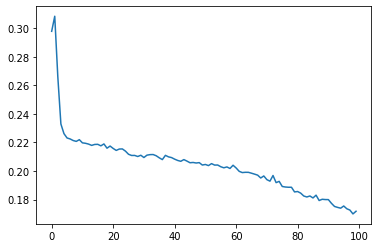

In [132]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [134]:
temperature = temperature
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 30ms/step


In [135]:
generated_notes.head(5)

,pitch,step,duration,start,end
0,55,0.350186,0.839716,0.350186,1.189901
1,72,0.589285,3.009212,0.939471,3.948683
2,55,0.566126,3.256825,1.505597,4.762423
3,68,0.480643,3.323794,1.986241,5.310035
4,64,0.527632,3.306801,2.513872,5.820673


In [136]:
out_file = f"{learning_rate}lrate_{batch_size}batch{epochs}epoch_{seq_length}seqlength_from_file_nb{file_number}.mid"
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
#display_audio(out_pm)
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_distributions(generated_notes)